# Homework on Mining Massive Databases (MMDS)

**by Andrii Shevtsov and Markiian Mandzak**

Task formulation:
![Task formulation screenshot](./task.jpg)

# Imports and constants

In [ ]:
import requests
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession, functions as F, types as T, Window
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, MinHashLSH
from pyspark.ml.linalg import SparseVector

from tree_stem import stem_word

/home/andrii/MMDS/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We set spark session here as it is a singletone for our application:

In [2]:
SPARK = SparkSession.builder \
    .appName("MMDS_HW_LSH") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

24/11/04 15:50:30 WARN Utils: Your hostname, ucuvm resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
24/11/04 15:50:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/04 15:50:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Other constants, that can be useful:

In [3]:
SEARCHED_ELEMENTS_COUNT = 20  # Count of elements that should occur in search with LSH
BEST_PARAMS_COUNT = 5  # Count of best param sets to return during the grid search
VECTOR_SIZE = 1000 # Size of the feature vector used

## Part 0. Common functions

Here, we list functions that are reutilized in both parts. This section is crucial in explaining our approach. Also it makes sure we use the same general approach for both tasks.

### Features calculation

In [4]:
@F.udf(T.ArrayType(T.StringType()))
def stem_and_clean(tokens):
    """A small UDF function to clean tokenized words from empty an then stem them"""
    return [stem_word(token) for token in tokens if token.strip() != ""]

In [5]:
def add_features(df, input_text_col: str, output_features_col: str = 'features'):
    """This function helps us to add vectors with features to the original dataframe with text
    
    Args:
        - df: pyspark DataFrame - a dataframe with `input_text_col` present, for which we should add a column with vectors of features
        - input_text_col: str - a name of column in `df` where we should take a text to obtain vector features
        - output_features_col: str - a name of a column in `df` where we should put final vectors with features

    Returns:
        pyspark DataFrame, with `output_features_col` column added and filled with feature vectors
    """

    # We need to remove symbols to correctly tokenize the text
    df = df.withColumn(f'{input_text_col}_clean', F.regexp_replace(input_text_col, r'_|:|\.|-|\(|\)|"|\'|«|»', ' '))

    tokenizer = Tokenizer(inputCol=f'{input_text_col}_clean', outputCol="words")
    df = tokenizer.transform(df)

    df = df.withColumn("stemmedWords", stem_and_clean(F.col("words")))

    hashingTF = HashingTF(inputCol="stemmedWords", outputCol="rawFeatures", numFeatures=VECTOR_SIZE)
    df = hashingTF.transform(df)

    idf = IDF(inputCol="rawFeatures", outputCol=output_features_col)
    idfModel = idf.fit(df)
    df = idfModel.transform(df)

    return df


### Ground truth similarity calculation

We should use some function to understand the distance (or similarity) between two feature vectors (for ground truth calculation). Cosine similarity is perfect for that:

In [6]:
@F.udf(T.DoubleType())
def cos_sim(vec_a, vec_b):
    if isinstance(vec_a, SparseVector) and isinstance(vec_b, SparseVector):
        dot_product = float(vec_a.dot(vec_b))
        norm_a = float(vec_a.norm(2))
        norm_b = float(vec_b.norm(2))
        return dot_product / (norm_a * norm_b) if norm_a and norm_b else 0.0
    return 0.0

Then, we need to have a function to calculate ground truth similarity and then obtaining ids of the closest elements:

In [7]:
def add_gt_similar(df, id_col: str, features_col: str = 'features', gt_similar_col: str = 'gt_similar', searched_elements_count: int = SEARCHED_ELEMENTS_COUNT):
    """Add column with lists of ids of similar ground truth elements
    
    Args:
        - df: pyspark DataFrame - a dataframe with `id_col` and `features_col` present, for which we should add a column with lists of similar items
        - id_col: str - a name of column in `df` where we should take indexes to put into `gt_similar_col`
        - features_col: str (default 'features') - a name of column in `df` where vector features are located
        - gt_similar_col: str (default 'gt_similar') - a name for a new column that is created as a result
        - searched_elements_count: int (default SEARCHED_ELEMENTS_COUNT) - maximum count of elements we want to search
    
    Returns:
    pyspark DataFrame, a copy of `df` with filled `gt_similar_col` that contains ids of ground truth similar items
    """

    # We can now make an `NxN` similarity table, containing cosine similarities between each pair of feature vectors
    similarity_table = (
        df.alias('a')
        .crossJoin(df.alias('b'))
        .withColumn(
            'cs',
            cos_sim(
                F.col(f'a.{features_col}'),
                F.col(f'b.{features_col}'),
            )
        )
        .groupBy(f'a.{id_col}')
        .pivot(f'b.{id_col}')
        .sum('cs')
        .orderBy(id_col)
    )

    # Now, we can obtain all the perspective similarity pairs (with similarity bigger than 0)
    similarity_columns = [column for column in similarity_table.columns if column != id_col]

    mapping_expr = []
    for c in similarity_columns:
        mapping_expr.extend([F.lit(c), F.col(c)])

    paired_df = similarity_table.select(
        F.col(id_col),
        F.explode(F.create_map(*mapping_expr)).alias("similar_id", "similarity")
    ).filter(
        (F.col(id_col) != F.col("similar_id")) & (F.col("similarity") > 0)
    )

    # And take top k similar items by the similarity value for each other item
    window_spec = Window.partitionBy(id_col).orderBy(F.col("similarity").desc())
    paired_df = paired_df.withColumn("simrank", F.row_number().over(window_spec)).filter(F.col("simrank") <= searched_elements_count)

    # Here we collect lists with similar ids and add them to the original dataframe 
    top_similarities_df = paired_df.groupBy(id_col).agg(F.collect_list("similar_id").alias(gt_similar_col))
    res_df = df.join(top_similarities_df, on=id_col, how='left').orderBy(id_col)

    return res_df

### Predicting with LSH

In [8]:
def predict_similar_lsh(df, lsh_params, id_col: str, features_col: str = 'features', pred_similar_col: str = 'pred_similar', searched_elements_count: int = SEARCHED_ELEMENTS_COUNT):
    """Predict similar items with MinHashLSH and add them to the original dataframe into the `pred_similar_col` column
    
    Args:
        - df: pyspark DataFrame - a dataframe with `id_col` and `features_col` present, for which we should add a column with lists of similar items
        - id_col: str - a name of column in `df` where we should take indexes to put into `pred_similar_col`
        - features_col: str (default 'features') - a name of column in `df` where vector features are located
        - pred_similar_col: str (default 'pred_similar') - a name for a new column that is created as a result
        - searched_elements_count: int (default SEARCHED_ELEMENTS_COUNT) - maximum count of elements we want to search
    
    Returns:
    pyspark DataFrame, a copy of `df` with filled `pred_similar_col` column that contains ids of predicted similar items
    """
    
    num_hash_tables = lsh_params['numHashTables']
    distance_threshold = lsh_params['distanceThreshold']

    mh = MinHashLSH(inputCol=features_col, outputCol="hashes", numHashTables=num_hash_tables)

    model = mh.fit(df)

    similar_items = model.approxSimilarityJoin(df, df, threshold=distance_threshold, distCol="similarity")
    similar_items = similar_items.filter(F.col(f"datasetA.{id_col}") != F.col(f"datasetB.{id_col}"))
    similar_items = similar_items.orderBy(F.col("similarity").desc())

    window_spec = Window.partitionBy(f"datasetA.{id_col}").orderBy(F.col("similarity").desc())
    similar_items = similar_items.withColumn("simrank", F.row_number().over(window_spec)).filter(F.col("simrank") <= searched_elements_count)

    found_items = similar_items.groupBy(f"datasetA.{id_col}").agg(F.collect_list(f"datasetB.{id_col}").alias(pred_similar_col))

    res_df = df.join(found_items, on=id_col, how='left')

    return res_df

### Measuring quality

Let's also define a function to calculate the quality of our prediction. We will use intersection over union (IOU) to evaluate quality, as it is intuitive and penalizes both false positives and false negatives equally:

In [9]:
@F.udf(T.DoubleType())
def iou_func(real_items, pred_items):
    if real_items is None:
        return 1.
    elif pred_items is None:
        return 0.
    else:
        real_items_set = set([int(i) for i in real_items])
        pred_items_set = set([int(i) for i in pred_items])
        intersection_len = len(real_items_set.intersection(pred_items_set))
        union_len = len(real_items_set.union(pred_items_set))
        # Division of integers here somehow breaks the logic when NULL is passed in
        return float(intersection_len)/float(union_len)  

Now we need a function that makes an evaluation of the current parameters set (using time and IOU) for the LSH prediction:

In [10]:
def test_lsh_params(df, params, id_col: str, features_col: str = 'features', pred_similar_col: str = 'pred_similar', searched_elements_count: int = SEARCHED_ELEMENTS_COUNT):
    """A function to measure performance of the LSH algorithm with given parameters
    
    Args:
        - df: pyspark DataFrame - a dataframe with `id_col` and `features_col` present, for which we should add a column with lists of similar items
        - id_col: str - a name of column in `df` where we should take indexes to put into `pred_similar_col`
        - features_col: str (default 'features') - a name of column in `df` where vector features are located
        - pred_similar_col: str (default 'pred_similar') - a name for a new column that is created as a result
        - searched_elements_count: int (default SEARCHED_ELEMENTS_COUNT) - maximum count of elements we want to search
    
    Returns:
    dict, a dictionary with lst parameters and results of model with that parameters
    """
    
    start_time = time.time()
    test_iou_df = predict_similar_lsh(df, params, 
                                      id_col=id_col, 
                                      features_col=features_col, 
                                      pred_similar_col=pred_similar_col,
                                      searched_elements_count=searched_elements_count)
    computation_time = time.time() - start_time

    test_iou_df = test_iou_df.withColumn("iou", iou_func(F.col("gt_similar_articles"), F.col("pred_similar_articles")))
    iou_value = test_iou_df.agg(F.avg("iou")).collect()[0][0]

    return {
        'params': params,
        'iou': iou_value,
        'computation_time': computation_time,
    }

### Performing grid search

Here is a function to perform grid search:

In [11]:
def grid_search_tuning(data, 
                       param_grid, 
                       id_col: str, 
                       features_col: str = 'features', 
                       pred_similar_col: str = 'pred_similar', 
                       searched_elements_count: int = SEARCHED_ELEMENTS_COUNT,
                       top_parameter_sets: int = BEST_PARAMS_COUNT):
    """A function to calculate test MinHashLSH with different parameters and find `top_parameter_sets` best

    Args:
        - df: pyspark DataFrame - a dataframe with `id_col` and `features_col` present, for which we should add a column with lists of similar items
        - param_grid: list of dicts - a list with paramer sets we want to evaluate on
        - id_col: str - a name of column in `df` where we should take indexes to put into `pred_similar_col`
        - features_col: str (default 'features') - a name of column in `df` where vector features are located
        - pred_similar_col: str (default 'pred_similar') - a name for a new column that is created as a result
        - searched_elements_count: int (default SEARCHED_ELEMENTS_COUNT) - maximum count of elements we want to search
        - top_parameter_sets: int (default BEST_PARAMS_COUNT) - count of best parameter sets we want to return. If <= 0; return all parameter sets
    
    Returns:
    list of dicts, a dictionary with lst parameters and results of model with that parameters
    """
    results = []
    for params in param_grid:
        result = test_lsh_params(data, 
                                 params, 
                                 id_col=id_col, 
                                 features_col=features_col, 
                                 pred_similar_col=pred_similar_col, 
                                 searched_elements_count=searched_elements_count)
        results.append(result)

    top_results = sorted(results, key=lambda x: x['iou'], reverse=True)
    if top_parameter_sets > 0:
        top_results = top_results[:top_parameter_sets]

    return top_results


### Visualizing results

In [41]:
def visualize_gridsearch_res(gridsearch_res):
    """Plot two heatmaps with gridsearch results"""
    gridsearch_res_df = pd.DataFrame(gridsearch_res)

    gridsearch_res_df['numHashTables'] = gridsearch_res_df['params'].apply(lambda x: x.get('numHashTables'))
    gridsearch_res_df['distanceThreshold'] = gridsearch_res_df['params'].apply(lambda x: x.get('distanceThreshold'))
    gridsearch_res_df = gridsearch_res_df.drop(columns=['params'])

    iou_pivot = gridsearch_res_df.pivot(index="numHashTables", columns="distanceThreshold", values="iou")
    time_pivot = gridsearch_res_df.pivot(index="numHashTables", columns="distanceThreshold", values="computation_time")

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    fig.suptitle("Results for different parameters")

    axs[0].set_title("IOU values for different parameter sets")
    sns.heatmap(iou_pivot, ax=axs[0], cmap='rocket_r')

    axs[1].set_title("Computation time values for different parameter sets, seconds")
    sns.heatmap(time_pivot, ax=axs[1], cmap='rocket')

    plt.show()

## Part 1. Barcelona LSH experiment

In [ ]:
!wget -O listings.csv.gz https://data.insideairbnb.com/spain/catalonia/barcelona/2024-09-06/data/listings.csv.gz
!wget -O calendar.csv.gz https://data.insideairbnb.com/spain/catalonia/barcelona/2024-09-06/data/calendar.csv.gz
!wget -O reviews.csv.gz https://data.insideairbnb.com/spain/catalonia/barcelona/2024-09-06/data/reviews.csv.gz

!gunzip -f listings.csv.gz
!gunzip -f calendar.csv.gz
!gunzip -f reviews.csv.gz

--2024-11-04 15:19:02--  https://data.insideairbnb.com/spain/catalonia/barcelona/2024-09-06/data/listings.csv.gz
Resolving data.insideairbnb.com (data.insideairbnb.com)... 108.138.51.6, 108.138.51.28, 108.138.51.93, ...
Connecting to data.insideairbnb.com (data.insideairbnb.com)|108.138.51.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9977937 (9.5M) [application/x-gzip]
Saving to: ‘listings.csv.gz’

listings.csv.gz     100%[===================>]   9.52M  10.2MB/s    in 0.9s    

2024-11-04 15:19:05 (10.2 MB/s) - ‘listings.csv.gz’ saved [9977937/9977937]

--2024-11-04 15:19:06--  https://data.insideairbnb.com/spain/catalonia/barcelona/2024-09-06/data/calendar.csv.gz
Resolving data.insideairbnb.com (data.insideairbnb.com)... 108.138.51.28, 108.138.51.6, 108.138.51.112, ...
Connecting to data.insideairbnb.com (data.insideairbnb.com)|108.138.51.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18042988 (17M) [application/x-gzip]
Savi

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

def create_info_df(df):
    info = pd.DataFrame(df.dtypes, columns=['type'])
    info['missing values'] = df.isnull().sum()
    info['example value'] = df.loc[0]
    return info

listings_df = pd.read_csv('listings.csv')
print(listings_df.shape)
create_info_df(listings_df)

In [ ]:
# Initialize Spark session
listings_df = SPARK.createDataFrame(listings_df)
# listings_df = listings_df.sample(False, 0.1) # REMOVE BEFORE FINAL RUN!

In [ ]:
# Select relevant columns (replace 'Title' with the correct column, e.g., 'name')
text_df = listings_df.select("name").na.drop()

# Tokenize the text (split into words)
tokenizer = Tokenizer(inputCol="name", outputCol="words")
wordsData = tokenizer.transform(text_df)

# Use HashingTF to create term frequency vectors
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=10000)
featurizedData = hashingTF.transform(wordsData)

# Calculate the TF-IDF
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

# Define a function to run LSH with MinHash
def run_lsh_experiment(data, params):
    # Extract parameters
    num_hash_tables = params['numHashTables']
    bucket_length = params['bucketLength']
    
    # Initialize LSH
    mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=num_hash_tables)
    
    # Fit the model
    model = mh.fit(data)
    
    # Perform Approximate Similarity Join
    similar_items = model.approxSimilarityJoin(data, data, threshold=bucket_length, distCol="JaccardDistance")
    
    # Filter out exact matches (self-pairs)
    similar_items = similar_items.filter(col("datasetA.name") != col("datasetB.name"))
    
    # Count number of similar pairs found
    count_similar_pairs = similar_items.count()
    
    return count_similar_pairs

# Function to tune parameters using Grid Search
def grid_search_tuning(data, param_grid):
    results = []
    for params in param_grid:
        start_time = time.time()
        similar_pairs_count = run_lsh_experiment(data, params)
        computation_time = time.time() - start_time
        results.append({
            'params': params,
            'similar_pairs_count': similar_pairs_count,
            'computation_time': computation_time
        })
    return results

# Define parameter grid for LSH
param_grid = [
    {'numHashTables': 3, 'bucketLength': 0.1},
    {'numHashTables': 3, 'bucketLength': 0.15},
    {'numHashTables': 3, 'bucketLength': 0.2},
    {'numHashTables': 4, 'bucketLength': 0.1},
    {'numHashTables': 4, 'bucketLength': 0.15},
    {'numHashTables': 4, 'bucketLength': 0.2},
    {'numHashTables': 5, 'bucketLength': 0.1},
    {'numHashTables': 5, 'bucketLength': 0.15},
    {'numHashTables': 5, 'bucketLength': 0.2}
]


# Run grid search for parameter tuning
results = grid_search_tuning(rescaledData, param_grid)

# Print results
for result in results:
    print(f"Params: {result['params']}, Similar Pairs: {result['similar_pairs_count']}, Time: {result['computation_time']}s")

### Configuration `numHashTables = 3` and `bucketLength = 0.15` looks the best

## Part 2. Wikipedia LSH experiment

### Obtain data

In [12]:
wiki_request_res = requests.get("https://wikimedia.org/api/rest_v1/metrics/pageviews/top/uk.wikipedia.org/all-access/2024/09/all-days", headers={
    "Accept": "application/json",
    "User-Agent": "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:129.0) Gecko/20100101 Firefox/129.0",
    "Referer": "https://doc.wikimedia.org/"
})

In [13]:
articles_data = wiki_request_res.json()['items'][0]['articles']

### Transform data

In [14]:
articles_df = SPARK.createDataFrame(articles_data)

In [15]:
articles_df.show(truncate=False)

+-----------------------------------------------+----+------+
|article                                        |rank|views |
+-----------------------------------------------+----+------+
|Головна_сторінка                               |1   |469652|
|Спеціальна:Пошук                               |2   |197066|
|Волинська_трагедія                             |3   |82508 |
|Klavdia_Petrivna                               |4   |79497 |
|Україна                                        |5   |61993 |
|YouTube                                        |6   |60683 |
|Сибіга_Андрій_Іванович                         |7   |58442 |
|Перша_світова_війна                            |8   |50199 |
|Національна_суспільна_телерадіокомпанія_України|9   |42675 |
|Масляков_Олександр_Васильович                  |10  |37677 |
|Нечуй-Левицький_Іван_Семенович                 |11  |37089 |
|Президентські_вибори_у_США_2024                |12  |35302 |
|Лавров_Сергій_Вікторович                       |13  |34938 |
|Білокур

Let's add vectors of features to the dataframe:

In [16]:
articles_df = add_features(articles_df, "article", "features")

In [17]:
articles_df.show()

+--------------------+----+------+--------------------+--------------------+--------------------+--------------------+--------------------+
|             article|rank| views|       article_clean|               words|        stemmedWords|         rawFeatures|            features|
+--------------------+----+------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    Головна_сторінка|   1|469652|    Головна сторінка| [головна, сторінка]|    [головн, сторін]|(1000,[560,705],[...|(1000,[560,705],[...|
|    Спеціальна:Пошук|   2|197066|    Спеціальна Пошук| [спеціальна, пошук]|  [спеціальн, пошук]|(1000,[416,722],[...|(1000,[416,722],[...|
|  Волинська_трагедія|   3| 82508|  Волинська трагедія|[волинська, траге...| [волинськ, трагеді]|(1000,[865,897],[...|(1000,[865,897],[...|
|    Klavdia_Petrivna|   4| 79497|    Klavdia Petrivna| [klavdia, petrivna]| [klavdia, petrivna]|(1000,[750,785],[...|(1000,[750,785],[...|
|             Україн

### Obtaining Ground Truth similarities

In [18]:
articles_df = add_gt_similar(articles_df, id_col='rank', features_col='features', gt_similar_col='gt_similar_articles')

Let's see newly added ground truth similar articles:

In [19]:
articles_df.show()

24/11/04 16:01:08 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/11/04 16:02:03 WARN DAGScheduler: Broadcasting large task binary with size 1085.8 KiB


+----+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|rank|             article| views|       article_clean|               words|        stemmedWords|         rawFeatures|            features| gt_similar_articles|
+----+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   1|    Головна_сторінка|469652|    Головна сторінка| [головна, сторінка]|    [головн, сторін]|(1000,[560,705],[...|(1000,[560,705],[...|[353, 857, 749, 7...|
|   2|    Спеціальна:Пошук|197066|    Спеціальна Пошук| [спеціальна, пошук]|  [спеціальн, пошук]|(1000,[416,722],[...|(1000,[416,722],[...|[465, 22, 42, 406...|
|   3|  Волинська_трагедія| 82508|  Волинська трагедія|[волинська, траге...| [волинськ, трагеді]|(1000,[865,897],[...|(1000,[865,897],[...|[936, 732, 837, 4...|
|   4|    Klavdia_Petrivna| 79497|

## Prediction with Locality Sensitive Hashing

Let's create  a parameters grid:

In [48]:
possibleHashTablesCount = [10, 20, 50, 100, 200]
possibleDistanceThresholds = [0.3, 0.5, 0.7, 0.9, 0.95, 0.97, 0.99]

param_grid = []
for hashTablesCount in possibleHashTablesCount:
    for distanceThreshold in possibleDistanceThresholds:
        param_grid.append({'numHashTables': hashTablesCount, 'distanceThreshold': distanceThreshold})

And perform the grid search. We want to obtain results for all the parameters to perform the visualization:

In [49]:
parameters_evaled = grid_search_tuning(articles_df, 
                                       param_grid, 
                                       id_col="rank", 
                                       features_col = 'features', 
                                       pred_similar_col = 'pred_similar_articles', 
                                       top_parameter_sets = -1)

24/11/04 16:52:29 WARN DAGScheduler: Broadcasting large task binary with size 1085.8 KiB
24/11/04 16:52:30 WARN DAGScheduler: Broadcasting large task binary with size 1227.4 KiB
24/11/04 16:52:31 WARN DAGScheduler: Broadcasting large task binary with size 1452.5 KiB
24/11/04 16:52:32 WARN DAGScheduler: Broadcasting large task binary with size 1243.4 KiB
24/11/04 16:52:32 WARN DAGScheduler: Broadcasting large task binary with size 1243.3 KiB
24/11/04 16:52:33 WARN DAGScheduler: Broadcasting large task binary with size 1211.4 KiB
24/11/04 16:52:33 WARN DAGScheduler: Broadcasting large task binary with size 1217.9 KiB
24/11/04 16:52:33 WARN DAGScheduler: Broadcasting large task binary with size 1215.8 KiB
24/11/04 16:52:34 WARN DAGScheduler: Broadcasting large task binary with size 1236.2 KiB
24/11/04 16:53:50 WARN DAGScheduler: Broadcasting large task binary with size 1085.8 KiB
24/11/04 16:53:51 WARN DAGScheduler: Broadcasting large task binary with size 1227.4 KiB
24/11/04 16:53:52 WAR

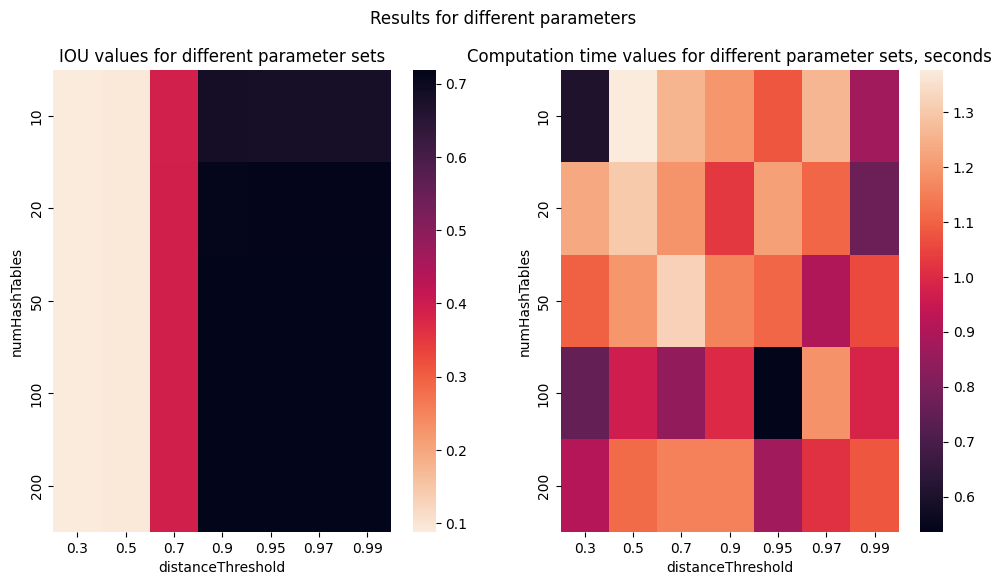

In [50]:
visualize_gridsearch_res(parameters_evaled)

In [51]:
print(f"The best parameter set is {parameters_evaled[0]['params']}. It has IOU={parameters_evaled[0]['iou']:.3f} and computation time of {parameters_evaled[0]['computation_time']:.3f} seconds")

The best parameter set is {'numHashTables': 200, 'distanceThreshold': 0.95}. It has IOU=0.719 and computation time of 0.871 seconds


## Part 3. Parameter substitution

## Final

In [27]:
SPARK.stop()

24/11/04 15:18:20 WARN TaskMemoryManager: Failed to allocate a page (33554416 bytes), try again.
24/11/04 15:18:21 WARN TaskMemoryManager: Failed to allocate a page (33554416 bytes), try again.
24/11/04 15:18:22 WARN TaskMemoryManager: Failed to allocate a page (33554416 bytes), try again.
24/11/04 15:18:22 WARN TaskMemoryManager: Failed to allocate a page (33554416 bytes), try again.
24/11/04 15:18:23 WARN TaskMemoryManager: Failed to allocate a page (33554416 bytes), try again.
24/11/04 15:18:24 WARN TaskMemoryManager: Failed to allocate a page (33554416 bytes), try again.
24/11/04 15:18:24 WARN TaskMemoryManager: Failed to allocate a page (33554416 bytes), try again.
24/11/04 15:18:25 WARN TaskMemoryManager: Failed to allocate a page (33554416 bytes), try again.
24/11/04 15:18:26 WARN TaskMemoryManager: Failed to allocate a page (33554416 bytes), try again.
24/11/04 15:18:27 WARN TaskMemoryManager: Failed to allocate a page (33554416 bytes), try again.
24/11/04 15:18:27 WARN TaskMem

KeyboardInterrupt: 

24/11/04 15:18:28 WARN TaskMemoryManager: Failed to allocate a page (33554416 bytes), try again.
24/11/04 15:18:29 WARN TaskMemoryManager: Failed to allocate a page (33554416 bytes), try again.
24/11/04 15:18:29 WARN TaskMemoryManager: Failed to allocate a page (33554416 bytes), try again.
24/11/04 15:18:30 WARN TaskMemoryManager: Failed to allocate a page (33554416 bytes), try again.
24/11/04 15:18:31 WARN TaskMemoryManager: Failed to allocate a page (33554416 bytes), try again.
24/11/04 15:18:31 WARN TaskMemoryManager: Failed to allocate a page (33554416 bytes), try again.
24/11/04 15:18:32 WARN TaskMemoryManager: Failed to allocate a page (33554416 bytes), try again.
24/11/04 15:18:33 WARN TaskMemoryManager: Failed to allocate a page (33554416 bytes), try again.
24/11/04 15:18:33 WARN TaskMemoryManager: Failed to allocate a page (33554416 bytes), try again.
24/11/04 15:18:34 WARN TaskMemoryManager: Failed to allocate a page (33554416 bytes), try again.
24/11/04 15:18:34 WARN TaskMem